Developer: **Rakesh Nain**

### Memory Event Producer

This python program loads all the data from “Streaming_Linux_memory.csv” and sending X number of records from each machine following the sequence to the Kafka stream every 10 seconds. Meanwhile, also generating Y number of
records with the same timestamp. These Y number of records will be sent after 10
seconds (or the next cycle)

A figure demonstrating the timeline is shown below.
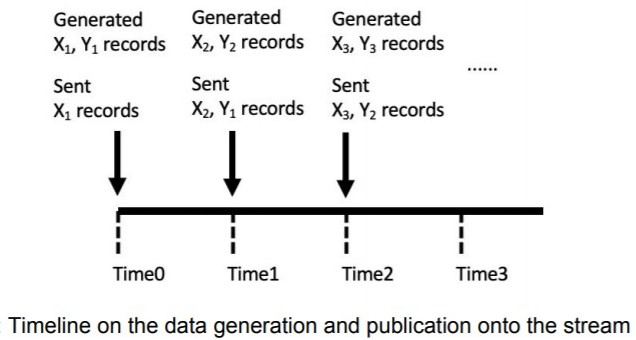

Where,

- The number X is a random number between 20~80 (inclusive), which is regenerated for each machine in each cycle.
- The number Y is a random number between 0~5 (inclusive), which is regenerated for each machine in each cycle.
- Appending event time in unix-timestamp format (as mentioned above).
- If the data is exhausted, restarting from the first sequence again.

In [5]:
# import statements
from time import sleep
from json import dumps
from kafka import KafkaProducer
producer = KafkaProducer(security_protocol="SSL", bootstrap_servers=os.environ.get('KAFKA_HOST', 'localhost:9092'))
import random
import datetime as dt
import csv

In [3]:
def read_csv(fileName):
    data = []
    with open(fileName, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
    
        for row in reader:
            data.append({'sequence': int(row['sequence']), 'machine': int(row['machine']), 'PID': int(row['PID']), 'MINFLT': int(row['MINFLT']), 'MAJFLT': int(row['MAJFLT']), 'VSTEXT': int(row['VSTEXT']), 'VSIZE': int(float(row['VSIZE'])), 'RSIZE': int(float(row['RSIZE'])), 'VGROW': int(float(row['VGROW'])), 'RGROW': int(float(row['RGROW'])), 'MEM': int(float(row['MEM'])), 'CMD': row['CMD']})
        
    return data

def publish_message(producer_instance, topic_name, data):
    try:
        producer_instance.send(topic_name, data)
        print('Message published successfully. Data: ' + str(data))
    except Exception as ex:
        print('Exception in publishing message.')
        print(str(ex))
        
def connect_kafka_producer():
    _producer = None
    try:
        _producer = KafkaProducer(bootstrap_servers=['localhost:9092'],
                                  value_serializer=lambda x: dumps(x).encode('ascii'),
                                  api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka.')
        print(str(ex))
    finally:
        return _producer
    
if __name__ == '__main__':
   
    topic = 'Streaming_Linux_memory5'
    cRows = read_csv('Streaming_Linux_memory.csv')
    
    print('Publishing records..')
    producer = connect_kafka_producer()
    
    machines_set = set()
    for a in cRows:
        machines_set.add(a['machine'])   
        
    machine_list = list(machines_set)
          
    g = globals()
    for m_num in machine_list:
        g['machine_{0}'.format(m_num)] = []
        
    for m_num in machine_list:
        for row in cRows:
            if row['machine'] == m_num:
                g['machine_{0}'.format(m_num)].append(row)
                
    data_machine = []           
    for m_num in machine_list:       
        data_machine.append(g['machine_{0}'.format(m_num)])
        
    start_list = [0]*len(data_machine)
    iteration = 0
    X = []
    Y = [[],[]]
    while True:
        produced_data = []
        produced_data_small = []
        for i in range(len(data_machine)):
            rand_n = random.randint(20, 80)
            if start_list[i]+rand_n < len(data_machine[i]):
                selected_data = data_machine[i][start_list[i]:start_list[i]+rand_n]
            else:
                start_list[i] = 0
                selected_data = data_machine[i][start_list[i]:start_list[i]+rand_n]
                
            for a in selected_data:
                a['ts'] = round(dt.datetime.utcnow().timestamp())
                produced_data.append(a)  
            start_list[i] = start_list[i] + rand_n
               
            rand_n_small = random.randint(0, 5)
            if start_list[i]+rand_n_small < len(data_machine[i]):
                selected_data = data_machine[i][start_list[i]:start_list[i]+rand_n_small]
            else:
                start_list[i] = 0
                selected_data = data_machine[i][start_list[i]:start_list[i]+rand_n_small]
            
            for a in selected_data:
                a['ts'] = round(dt.datetime.utcnow().timestamp())
                produced_data_small.append(a)
            start_list[i] = start_list[i] + rand_n_small
        
        if iteration == 0:
            X = produced_data
            publish_message(producer, topic, X)
            Y[0] = produced_data_small
        
        else:
            Y[1] = Y[0] + produced_data_small
            X = produced_data
            X_plus_Y = X + Y[0]
            publish_message(producer, topic, X_plus_Y)
            Y[0] = Y[1]
            
        iteration = iteration + 1
        sleep(10)
        

Publishing records..
Message published successfully. Data: [{'sequence': 1, 'machine': 4, 'PID': 4392, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192499}, {'sequence': 2, 'machine': 4, 'PID': 4397, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192499}, {'sequence': 3, 'machine': 4, 'PID': 4398, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192499}, {'sequence': 4, 'machine': 4, 'PID': 4400, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192499}, {'sequence': 5, 'machine': 4, 'PID': 4401, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts'

Message published successfully. Data: [{'sequence': 48, 'machine': 4, 'PID': 4413, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192509}, {'sequence': 49, 'machine': 4, 'PID': 4414, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192509}, {'sequence': 50, 'machine': 4, 'PID': 4415, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192509}, {'sequence': 51, 'machine': 4, 'PID': 4416, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192509}, {'sequence': 52, 'machine': 4, 'PID': 4417, 'MINFLT': 221, 'MAJFLT': 0, 'VSTEXT': 596, 'VSIZE': 184, 'RSIZE': 5668, 'VGROW': 184, 'RGROW': 5668, 'MEM': 0, 'CMD': 'apache2', 'ts': 1604192509}, {

Message published successfully. Data: [{'sequence': 119, 'machine': 4, 'PID': 2777, 'MINFLT': 0, 'MAJFLT': 0, 'VSTEXT': 10, 'VSIZE': 1, 'RSIZE': 77872, 'VGROW': 0, 'RGROW': 0, 'MEM': 0, 'CMD': 'compiz', 'ts': 1604192519}, {'sequence': 120, 'machine': 4, 'PID': 2801, 'MINFLT': 9, 'MAJFLT': 0, 'VSTEXT': 1350, 'VSIZE': 1, 'RSIZE': 46668, 'VGROW': 0, 'RGROW': 0, 'MEM': 0, 'CMD': 'nautilus', 'ts': 1604192519}, {'sequence': 121, 'machine': 4, 'PID': 4185, 'MINFLT': 0, 'MAJFLT': 0, 'VSTEXT': 2132, 'VSIZE': 2, 'RSIZE': 28312, 'VGROW': 0, 'RGROW': 0, 'MEM': 0, 'CMD': 'ostinato', 'ts': 1604192519}, {'sequence': 122, 'machine': 4, 'PID': 4188, 'MINFLT': 0, 'MAJFLT': 0, 'VSTEXT': 978, 'VSIZE': 3, 'RSIZE': 25108, 'VGROW': 0, 'RGROW': 0, 'MEM': 0, 'CMD': 'drone', 'ts': 1604192519}, {'sequence': 123, 'machine': 4, 'PID': 2536, 'MINFLT': 0, 'MAJFLT': 0, 'VSTEXT': 589, 'VSIZE': 630, 'RSIZE': 23744, 'VGROW': 0, 'RGROW': 0, 'MEM': 0, 'CMD': 'hud-service', 'ts': 1604192519}, {'sequence': 124, 'machine': 4

KeyboardInterrupt: 